In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pyccl as ccl
import os.path 
import math
from os.path import exists as file_exists

In [2]:
choose_file = []
for i in range(0,6):
    for j in range(0,12):
        for filename in os.listdir('/mnt/zfsusers/anyabua/FermiX'):
            if filename == "W_galagam_" + str(i)+"x"+str(j)+".npz":
                choose_file.append(str(filename))
data_files = np.reshape(choose_file,(6,12))

ells = np.load(data_files[0][0])['ells']
all_jackerrors = {f'jkerr{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['jack_error']) for gal in range(6) for gam in range(12)} 
all_pcl = {f'galaxy x gamma:{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['PCL_fskydivided']) for gal in range(6) for gam in range(12)} 
all_bpw = {f'bpw{gal}x{gam}': np.load(data_files[gal][gam])['bpw'] for gal in range(6) for gam in range(12)} 
all_JKCL = {f'JKCL{gal}x{gam}': np.load(data_files[gal][gam])['JKCL'] for gal in range(6) for gam in range(12)}

In [3]:
z = {}
dndz = {}
for gal in range(0,6):
    z[f'{gal}'], dndz[f'{gal}'] = np.loadtxt(f"dndz_bin{gal}.txt", unpack=True)

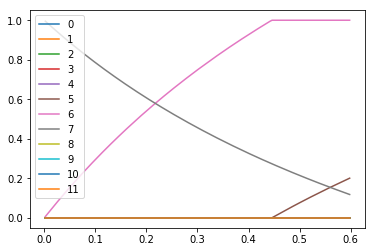

In [4]:
Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06])

def heaviside(x,y):
    return 1*(x>y)

z_4test = np.ones((150))

redshifted1 = np.zeros((13,150))
for i in range(13):
    redshifted1[i] = Edges[i]//(1+z['3']) #z_4test #


#redshifted is now an array of an array of redshifted energies, where the dimension of 
#the array within the array is equal to the 13xdim(z) where 13 corresponds to the 13 energy edges. 



windows = []

for n in range(12):
    for i in range(12):
        for k in range(150):
            w = (min(Edges[i+1],redshifted1[n+1,k])-max(Edges[i],redshifted1[n,k]))*heaviside(redshifted1[n+1,k],Edges[i])*heaviside(Edges[i+1],redshifted1[n,k])/(Edges[i+1]-Edges[i])
            windows.append(w)
    
windows = np.reshape(windows,(12,12,150))

for i, w in enumerate(windows[7]):
    plt.plot(z['3'], w, label=f'{i}')
plt.legend()


In [5]:
from scipy.special import sici

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96) #need to make a K(z) function
k_arr = np.geomspace(1E-4,100,256)
a = 1./(1+z['3']) 
a_arr = a[::-1]
chi = ccl.comoving_radial_distance(cosmo,a_arr)[::-1]


# We will use a mass definition with Delta = 200 times the matter density
hmd_200c = ccl.halos.MassDef200c() 

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

class DarkMatterAnnihilationProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation):
        self.cM = c_M_relation
        super().__init__()
        
    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _fourier(self, cosmo, k , M , a , mass_def):
        rho_matter = cosmo.rho_x(1., "matter", is_comoving=True)
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
    
        
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #comoving virial radius
        c_M =self._get_cM(cosmo,M_use,a,mass_def)
    
        R_s = R_M / c_M
        rho0 = M_use / (4 * np.pi * R_s**3*rho_matter**2)

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        P1 = M_use /((np.log(1 + c_M) - c_M/ (1 + c_M))**2)
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si_qc, Ci_qc = sici(q*c_M)
        
        A = (rho0 * P1)[:, None] / q
        
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q
        
        q_half = (1-(q**2)/2)
        q_sixth = (q-(q**3)/6)
        
        Si_term = Si1*(q_half*np.cos(q)+ q_sixth*np.sin(q))
        Ci_term = Ci1*(q_half*np.sin(q)-q_sixth*np.cos(q))
        
        sin_term = np.sin(q*c_M)*((6*(1 + c_M)**2 + 5 + 3*c_M - (q**2)*(1+c_M)**2)/(6*(1 + c_M)**3))
        cos_term = q*np.cos(q*c_M)*(4 + 3*c_M)/(6*(1 + c_M)**2)
      
        prof = A*(Si_qc - Si_term + Ci_term - 2*q/3 + sin_term + cos_term)
     
        
        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
    
        return prof
        
                           

pDM = DarkMatterAnnihilationProfile(cM)


hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c)
pk_DMxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pDM, prof2=pM,
                                  normprof1=True, normprof2=True,
                                  lk_arr=np.log(k_arr), a_arr=a_arr)
pk_MxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM, prof2=pM,
                                 normprof1=True, normprof2=True,
                                 lk_arr=np.log(k_arr), a_arr=a_arr)

In [6]:
#need to compute cl's for multiple galaxies. No need to compute new window function as window function only depends on z,
#each galaxy is measured at the same z's anyways. Just need to find cl theory for each galaxy. Can reorganise the cl theory and 
#cl data to match up so that we can now calculate the vectors and matrices needed to get F 


bias = np.array([1.182,1.086,1.126,1.144,1.206,1.548])
mean_z = np.array([0.075,0.125,0.175,0.225,0.275,0.325])


rho_x = ccl.background.rho_x(cosmo,1,'matter',is_comoving = True)
#omega_x = ccl.background.omega_x(cosmo,1,'matter')

C = (rho_x*(1+z['3']))**2/(8*np.pi)


################ GALAXY TRACER ###############################

t_g = []
for gal in range(0,6):
    t_gal = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z[f'{gal}'],dndz[f'{gal}']), bias=(mean_z, bias))
    t_g.append(t_gal)
    
galtracer = np.array(t_g)
#print(galtracer.shape)

######### GRB TRACER ########################################



#print(gam_kernel[143])
#print(gam_kernel.shape)

cl_th = np.zeros([6, 12, 12, 24])
for ig, g in enumerate(galtracer):
    for i in range(12):
        for j in range(12):
            GRB_tracer = ccl.Tracer()
            GRB_tracer.add_tracer(cosmo, kernel=(chi, C*windows[i, j]))
            cl_theoretical = ccl.angular_cl(cosmo, g, GRB_tracer, ells, p_of_k_a=pk_DMxMf)
            cl_th[ig, i, j, :] = cl_theoretical

#C_{l}^{g,i} = \sum_{n}F_{n}C_{l}^{g,i,n}
#the shape of cl_th goes as (x,y,z,m) where x corresponds to the gth index of the galaxy redshift bins, i.e there are 6 g's
# the yth index corresponds the the ith index for the gamma ray energy bins. The ith index comes before the yth index because of how the loops run.
#if the loops ran with gam_kernel first then gal_tracer then the it would be (y,x,z,m)
#There are 12 energy bins. so for each galaxy redshift bin there are 12 corresponding 
#gamma ray energy bins, and for each of these energy bins, there will be the nth index running over 12 energy bins. This nth index corresponds to the summation of F.
# to put it simply, we sum over 12 n's for each i and g.
# there are 24 l's for each of the n's. 




In [7]:
A_matrix = np.zeros([6, 12, 12])
ecl = np.array([[all_jackerrors[f'jkerr{g}x{i}'] for i in range(12)] for g in range(6)])
data_cl  = np.array([[all_pcl[f'galaxy x gamma:{g}x{i}']for i in range(12)]for g in range(6)])

for g in range(6):
    for n in range(12):
        for m in range(12):
            A_matrix[g, n, m] = np.sum(cl_th[g,:,n,:]*cl_th[g,:,m,:]/ecl[g, :, :]**2) 

            
            
            
def check_posdef(x):
    return np.all(np.linalg.eigvals(x) > 0)

check_posdef(A_matrix[0])



b = np.zeros([6,12])

for g in range(6):
    for n in range(12):
        b[g,n] = np.sum(cl_th[g,:,n,:]*data_cl[g,:,:]/ecl[g,:,:]**2)

#print(b[1])

F = np.zeros([6,12])
for g in range(6):
    F[g] = np.linalg.solve(A_matrix[g],b[g])

bestcl = np.zeros([6,12,24])
for g in range(6):
    for i in range(12):
        for el in range(24):
            bestcl[g,i,el] = np.sum(F[g,:]*cl_th[g,i,:,el])
print(F[4])

[ 6.73660530e-30 -5.87970701e-31  4.56411450e-32  1.28381340e-30
  2.08557761e-31  1.17332923e-31 -6.46197735e-32  2.60853508e-31
 -7.54608893e-32  1.91554801e-31 -1.55556133e-31  8.73182451e-32]


In [8]:
b_comb = np.sum(b, axis = 0)
A_comb = np.sum(A_matrix, axis = 0)
F_comb = np.linalg.solve(A_comb,b_comb)
F_cov2 = np.linalg.inv(A_comb)


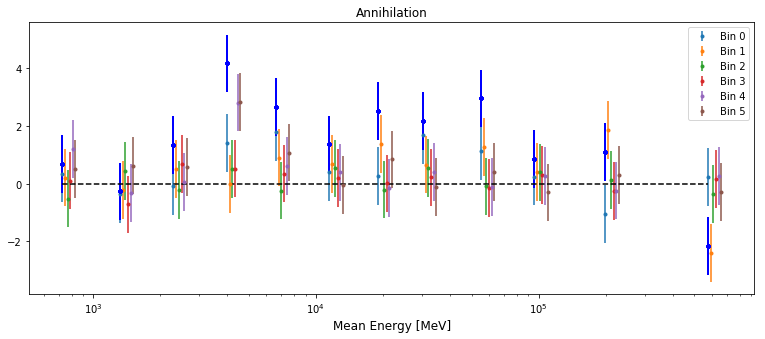

In [9]:
cov_F = np.linalg.inv(A_matrix)

#E_mean = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))
f = plt.figure()
#print(E_mean)


geomE_mean = np.sqrt(np.array(Edges[1:])*np.array(Edges[:-1]))


for i in range(6):
    plt.errorbar(geomE_mean*(1+0.03*i), F[i]/np.sqrt(np.diag(cov_F[i])), yerr=np.ones(12), fmt='.', label=f'Bin {i}')
    
    
for i in range(12):
    plt.errorbar(geomE_mean, F_comb/np.sqrt(np.diag(F_cov2)), yerr=np.ones(12), fmt='b.')

plt.xscale('log')
plt.legend()
plt.plot(geomE_mean, np.zeros(12), 'k--')

f.set_figwidth(13)
f.set_figheight(5)
plt.xlabel('Mean Energy [MeV]',fontsize = 12)
plt.title('Annihilation')
plt.savefig('ann_plot.jpg')

In [10]:
print('this is b')
print(b.shape)
print('this is A')
print(A_matrix.shape)
print(F.shape)

this is b
(6, 12)
this is A
(6, 12, 12)
(6, 12)


In [11]:
#coadd
b_comb = np.sum(b, axis = 0)

A_comb = np.sum(A_matrix, axis = 0)

[ 2.22530412e-30 -2.68116345e-31  5.47112111e-31  9.11415449e-31
  3.53452521e-31  1.11903210e-31  1.30509120e-31  9.55105863e-32
  7.79048289e-32  1.52193994e-32  1.44040824e-32 -1.30448688e-32]
4.411869804809843e-61


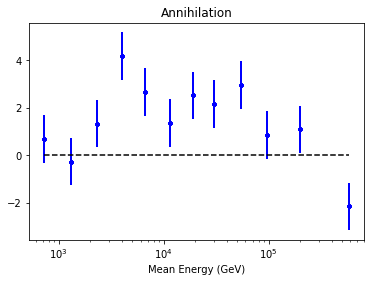

In [12]:
#print(b_comb)
#print(A_comb)

F_comb = np.linalg.solve(A_comb,b_comb)
F_cov2 = np.linalg.inv(A_comb)
print(F_comb)
print(np.cov(F_comb))
for i in range(12):
    plt.errorbar(geomE_mean, F_comb/np.sqrt(np.diag(F_cov2)), yerr=np.ones(12), fmt='b.')
plt.xscale('log')
plt.plot(geomE_mean, np.zeros(12), 'k--')
plt.xlabel('Mean Energy (GeV)')
plt.title('Annihilation')
plt.savefig('CoaddedFAnnihilation.jpg', dpi = 300)